## Massive Processing using atoms

The usual numpy/scipy way of processing data works great when the data of interest fit in memory. To deal with huge datasets, xdas introduce Atom objects.
An Atom is a generic processing unit that takes one input and return one output. Atoms can store state information to ensure continuity from subsequent calls on contiguous chunks. There are three ways to make atoms with xdas:
- Function can be atomized using the Partial class. All parameters except the input are fixed.
- The xdas.atoms module contains a set of predefined atoms. In particular most stateful atoms are implemented in that module.
- The user can subclass the Atom class and define its own atoms.


In [1]:
import numpy as np
import xdas as xd
import xdas.signal as xs

## Working with Atoms

In [2]:
import xdas.atoms as xa

## Transforming a classic workflow into an atomic pipeline

Imagine you tested the following workflow on a small subset of your data:

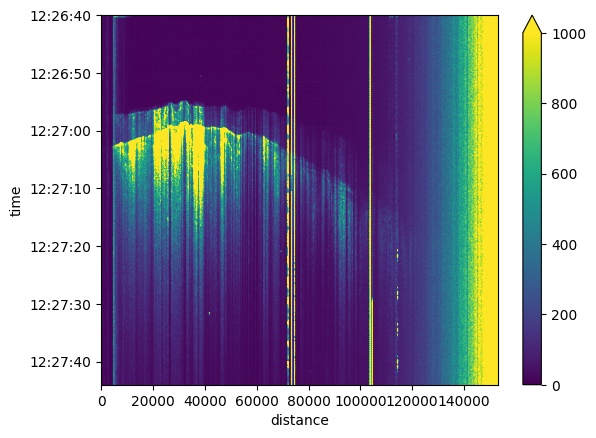

In [3]:
from scipy.signal import iirfilter

# load previously extracted event
da = xd.open_dataarray("outputs/event.nc")

b, a = iirfilter(4, 0.1, btype="high")


def process(da):
    da = xs.decimate(da, 2, ftype="fir", dim="distance")  # not impacted by chunking
    da = xs.lfilter(b, a, da, dim="time")  # require state passing along time
    da = np.abs(da)  # already a unary operator
    return da


monolithic = process(da)

monolithic.plot(yincrease=False, vmin=0, vmax=1e3, interpolation="antialiased")

To convert your workflow into an atomic pipeline you need:

1. to convert each processing step into an atom
2. to bundle all steps into a Sequential atom.

Converting each processing step into an atom depend on the nature of the step. In particular it depends wether the operation is stateful (it does rely on the history along the chunked dimension) or stateless (the operation can by applied separately on each chunk along the given dimension without any particular consideration). An example of a stateful operation is a recursive filter, passing on the state from t to t+1.Not that this stateful/less caracteristic depends on the chunking dimension.

- unary operators that are not stateful (that do not rely on the history along the chunked axis) can be used as is.
- functions that are not stateful must be wrapped with the Partial class.
- functions that are stateful must be replaced by an equivalent stateful object.

In practice, the atomized workflow can be implemented like below. The resulting atom is a callable that can be applied to any data array.

In [4]:
atom = xa.Sequential(
    [
        xa.Partial(
            xs.decimate, 2, ftype="fir", dim="distance"
        ),  # use Partial when stateless
        xa.LFilter(b, a, dim="time"),  # use equivalent atom object if stateful
        np.abs,  # do nothing if unary and stateless
    ]
)

atomic = atom(da)

assert atomic.equals(monolithic)  # works as `process` but can by applied chunk by chunk

### Applying an atom chunk by chunk

While atoms can be used as an equivalent of functions to organize pipelines, their major selling points is their abilities to enable chunk processing. While chunk by chunk processing can be done manually, xdas provides the xdas.processing module to facilitate this operation. The user must define one data loader and one data writer. Then the process() function is used to run the computation.

In [5]:
import xdas.processing as xp

In the example below the data array is loaded by chunks of 100 samples along the "time" dimension. Each chunk is processed by the atom that was defined above and each resulting processed chunk is saved in the output folder. Once the computation is completed, the data loader return a unified view on the output chunks.

In [6]:
!rm -rf outputs/chunks
!mkdir -p outputs/chunks

In [7]:
dl = xp.DataArrayLoader(da, chunks={"time": 1000})
dw = xp.DataArrayWriter("outputs/chunks")
chunked = xp.process(atom, dl, dw)

assert chunked.equals(
    monolithic
)  # again equal but could be applied to much bigger datasets

100%|██████████| 76.3M/76.3M [00:00<00:00, 94.6MB/s, read=1.3%, proc=98.7%, write=0.0%] 


## Example: Using PhaseNet on big datasets

To be able to use phasenet you need to install `seisbench` manually (already done at the beginning of this tutorial)

In [8]:
from seisbench.models import PhaseNet

In [9]:
!rm -f outputs/picks.csv

In [10]:
# This time let's work on the whole duration
da = xd.open_dataarray("outputs/singlecable.nc")

# reduce a bit the volume for this tutorial
da = da.sel(time=slice("2023-11-03T12:24:00", None))
da = da.isel(time=slice(None, 20_000))
da = da.sel(distance=slice(None, 100_000))

# Load the phase net model
model = PhaseNet.from_pretrained("diting")

dl = xp.DataArrayLoader(da, {"time": 10_000})
dw = xp.DataFrameWriter("outputs/picks.csv", parse_dates=["time"])

atom = xa.Sequential(
    [
        xs.integrate(..., dim="distance"),
        xs.decimate(..., 4, ftype="fir", dim="distance"),
        xs.sliding_mean_removal(..., 1000.0, dim="distance"),
        xa.ResamplePoly(100.0, dim="time"),
        xa.MLPicker(model, "time", device="cpu"),
        xa.Trigger(thresh=0.3, dim="time"),
    ]
)

picks = xp.process(atom, dl, dw)

100%|██████████| 249M/249M [00:30<00:00, 8.53MB/s, read=0.0%, proc=100.0%, write=0.0%]


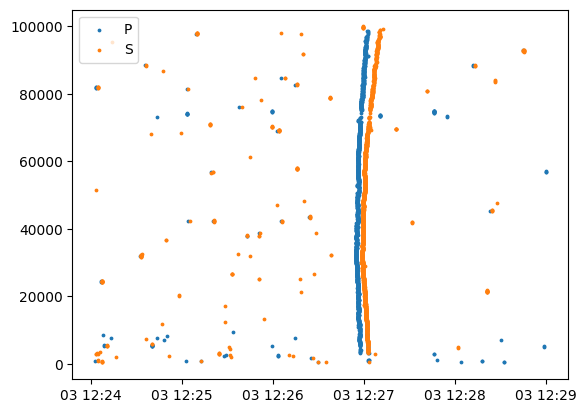

In [11]:
import matplotlib.pyplot as plt

picks_p = picks[picks["phase"] == "P"]
picks_s = picks[picks["phase"] == "S"]

plt.scatter(picks_p["time"], picks_p["distance"], label="P", s=3)
plt.scatter(picks_s["time"], picks_s["distance"], label="S", s=3)

plt.legend()
plt.show()